**Example Usage of LinkingLines Module**

The goal of this code is to link colinear line segments spread over Cartesian space in the Hough Transform coordinates. It takes the endpoint coordinates of line segments and performs clustering on them and outputs the combined lines and analyctics on it. This code was used to produce [Kubo Hutchison et al., 2023](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022GC010842)

This example replicates the process of linking dike segments for the Spanish Peaks Dike Swarm in Colorado, USA. Exposure bias, the uneven mapping of dikes, has segmented the dikes so their true lengths can only be estimated. This code links the far reaching segments based on orientation. Later we will also show a post processing step where different parts of the swarm can be extracted. 

In this example we will go through many of the tools available in this module. The process is: 

1. Load in a CSV file with [Well-Known-Text](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) format
2. Create a [pandas](https://pandas.pydata.org/) DataFrame of the data
3. Perform the [Hough Transform](https://en.wikipedia.org/wiki/Hough_transform)
4. Visualize the Results
5. Cluster based on Hough Space
6. Make lines out of clusters
7. Visualize and examine results
8. Save data for QGIS operability
9. Feature extraction
10. Save features
   

In [33]:
#Let's begin by loading the modules 

#previously published packages
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import scipy.cluster.hierarchy as sch
import os
import seaborn as sns
from datetime import datetime
import matplotlib.gridspec as gridspec


import sys
sys.path.append("../src")
sys.path.append("../data/spanish peaks")

# Packages written for the paper
from HT import HoughTransform
from ClusterLines import AggCluster
from PlotUtils import DotsLines, plotScatterHist, pltRec, DotsHT
from PrePostProcess import * 
from ExamineLines import examineClusters, checkoutCluster
from FitRadialCenters import RadialFit, NearCenters, CenterFunc


In [11]:
# Load the example dataset 

#load it using pandas.read_csv
# the CSV must have a column called "WKT" and can have any other data 
dikeset=pd.read_csv('/home/akh/myprojects/Dikes_Linking_Project/dikedata/spanish peaks/SpanishPeaks_3857.csv')

#Preprocessing step
dikeset=DikesetReProcess(dikeset)


The preprocssing step does several things necessary to run the algorithm. First it converts the WKT strings into "Xstart" "Xend" "Ystart" and "Yend" columns in the dataframe. It checks to make sure there are no duplicate dikes in the database. Then it checks to make sure each of the entries in the dataframe is a straight line. 

The straight line checking is performed by fitting a line to all the points in the WKT string and only accepting the entry if the fit of the line is significant.

It also calculates several other useful metrics including segment length and gives each segment a unique hash. The hash ID can be useful later to check the uniqueness of your clusters. 

The next step is to perform the Hough Transform

Besides the data the input in the hough transform code is the center (xc,yc)
which is assumed to be the mean of the X and Y coordinates. It can be set arbitrarily. You may wish to set this to investigate structures in your dataset. But most people will use the default settings 

It outputs theta, rho, xc, yc which then are added to the dataset as columns. 


In [12]:

theta, rho, xc,  yc=HoughTransform(dikeset)
print(xc,yc) 
dikeset['theta']=theta #Add to the dataframe in a column called 'theta'
dikeset['rho']=rho

print(dikeset.columns)

-11684130.47751338 4503174.613590027
Index(['Unnamed: 0.2', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1',
       'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1', 'id', 'Formation', 'Xstart', 'Ystart', 'Xend',
       'Yend', 'seg_length', 'rho', 'theta', 'HashID', 'Xmid', 'Ymid', 'yc',
       'xc', 'PerpOffsetDist', 'PerpIntX', 'PerpIntY', 'Date_Changed',
       'ScaledRho', 'Labels'],
      dtype='object')


The module includes custom code to visualize the cartesian and hough transform spacce next to eachother which is a useful exercise when learning about the hough transform. 

'DotsLines' is a useful tool which creates a matplotlib figure with two subplots with cartesian space on the left and hough space on the right. The 'ColorBy' argument can be used to color the segments and data by any of the data columns in the pandas dataframe. 

*Try to color it by "seg_length".*

km scale label


/home/akh/myprojects/Dikes_Linking_Project/Linking-and-Clustering-Dikes/scripts/../src/plotmod.py:1198: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


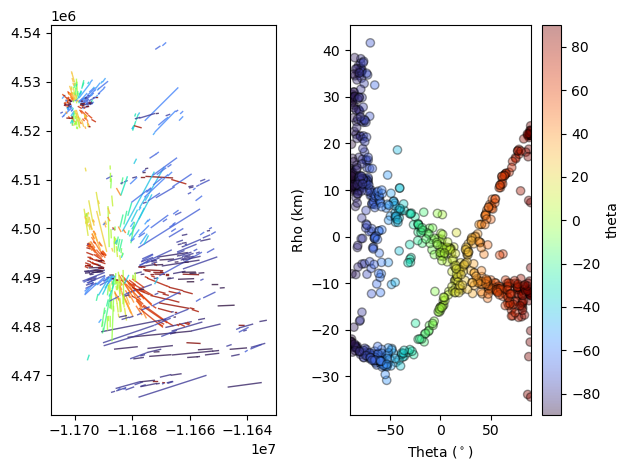

In [13]:
fig,ax=DotsLines(dikeset, ColorBy='theta')


We can now use the clustering portion of the code to link the scattered line segments for data reduction or analysis. 

We use agglomerative clustering to perform and advise people choose "complete" linkage to avoid chainning which will not yield colinear segments. Read more about [agglomerative clustering here](https://en.wikipedia.org/wiki/Hierarchical_clustering) and the [implementation here](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html). 

The algorithm takes the data as input and it takes two scaling factors dtheta, and drho. These two scaling factors are used to set the maximum distances over which two segments will be clustered. The maximum distance,d, is set to one. 

$$
d=\sqrt( (\frac{\theta_{1}-\theta_{2}}{dtheta})^{2}+(\frac{\rho_{1}-\rho_{2}}{dtheta})^{2})
$$

This way if the distance between two points is greater than dtheta or drho or the combination of the two they will not cluster (this is true for complete linkage only). 

The units of drho are length (usually meters) and degrees for dtheta.

*Try changing drho and dtheta and seeing how the results change.*

Another important function we introduce here is examineClusters. This function takes the dikeset data with labels assigned by AggCluster and outputs the linked lines along with some useful metrics such as average angle in the cluster, average rho, standard deviations of rho and theta, cluster size, and the ratio of the cluster length to the nearest neighbor distance within a cluster. 

The lines pandas dataframe is the linked dataset which can now be analyzed. 

Note that the columns in 'lines' are different than the ones we're used to in 'dikeset'.

rotating dataset by 44.69862137669443
km scale label
Index(['Label', 'Xstart', 'Ystart', 'Xend', 'Yend', 'X0', 'Y0', 'AvgRho',
       'AvgTheta', 'AvgSlope', 'AvgIntercept', 'RhoRange', 'Aspect', 'Xmid',
       'Ymid', 'PerpOffsetDist', 'PerpOffsetDistRange', 'NormPerpOffsetDist',
       'ThetaRange', 'StdRho', 'StdTheta', 'R_Width', 'R_Length', 'Size',
       'R_error', 'Linked', 'SegmentLSum', 'ClusterHash', 'ClusterCrossesZero',
       'EnEchelonAngleDiff', 'Overlap', 'nOverlapingSegments', 'EEPvalue',
       'MaxSegNNDist', 'MedianSegNNDist', 'MinSegNNDist', 'TrustFilter',
       'Date_Changed', 'xc', 'yc'],
      dtype='object')


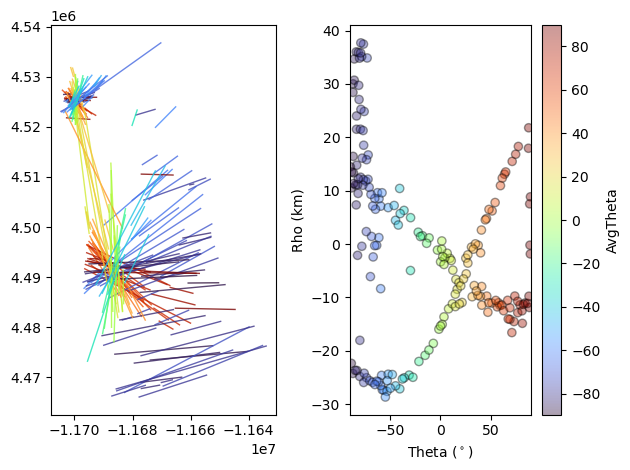

In [14]:
dtheta=2 
drho=np.floor(dikeset['seg_length'].mean())

dikeset, Z=AggCluster(dikeset, dtheta, drho, linkage='complete', rotate=True, metric='Euclidean')
lines,evaluation=examineClusters(dikeset) #this function takes all the data with the labels 

fig,ax=DotsLines(lines, ColorBy='AvgTheta')
print(lines.columns)

[examineClusters]() fits a rectangle over the clustered line segments returns the average line which fits between the end points of the two furthest segments explore this with [pltRec](). We can continue and use various metrics produced in 'examineClusters' to continue our analysis. Please see the documentation for [examineClusters]() to see all the metrics output. 

The [plotScatterHist]() uses [Seaborn](https://seaborn.pydata.org/) style to make plots of two variables in the DataFrame with histograms on the axes. 

*Try experimenting with plotting different parts of the dataframe.*



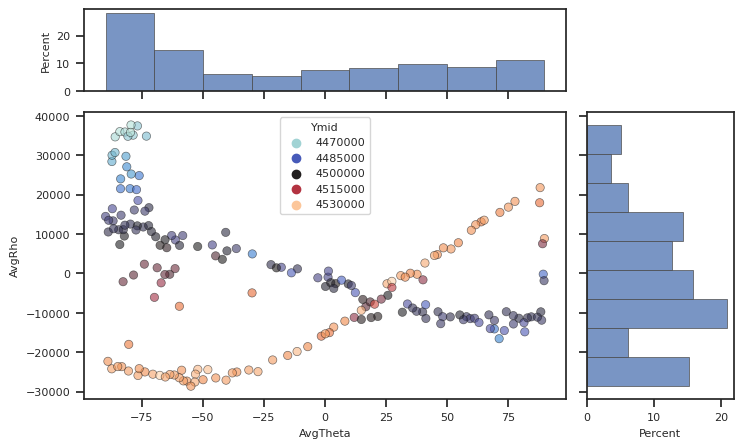

In [19]:
fig, [ax_main, ax_xDist, ax_yDist]=plotScatterHist(lines, "AvgTheta", 
                                                   "AvgRho", hue='Ymid', palette="icefire")

Finally, when you are happy with the clustering results you can export them into a CSV file and read it into a GIS software. If you don't need the GIS operability you can use [pd.to_csv](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html).

The format we export is a column in the CSV called Well Known Text. 

It looks like: 'LINESTRING (30 10, 10 30, 40 40)'. We use the function [writeToQGIS]() and recommend using [QGIS](https://www.qgis.org/en/site/) or other GIS software. 

You can see a tutorial for loading these types of files into QGIS [here](https://gis.stackexchange.com/questions/175582/how-to-load-my-csv-file-with-wkt-to-qgis).

In [ ]:
writeToQGIS(lines, 'SpanishPeaks_ClusteringResults.csv')

**Using the Hough Transfrom for Feature Extraction**

One may have different motives for clustering such as data reduction but the Hough Transform may also be used to extract features of the dataset. This code was written to extract radial or circumferential type dike swarms. Dike swarms, and many other types of linear features, can form different organized patterns.

![Ernst (2014), Large Igneous Provinces](dikeswarms.png)

We can use the Hough Transform to extract these. See [this page]() for more on the theory of the Hough Transform.

The Spanish Peaks dataset shows a great example of this because it contains two radial type swarms and an overlaping linear swarm.
We can use the [fitRadial]() functions to extract these. This function fits the equation 

$$
\rho=(x_{r}-xc)\cos(\theta)+(y_{r}-yc)\sin(\theta)
$$

where $(x_{r}, y_{r})$ is the location of intersection of the radiating form. In the case of dikes this might indicate a magma source or a volcanic landform. 


When you plot the data and color by 'Ymid' using [plotScatterHist]() you can clearly see two sinusoidal curves and one "bar" which represent the three trends. We can filter by 'Ymid' and put it into [fitRadial](). 

In [27]:

#Lets filter by 'Ymid'

#Radial 1 - we will color with Purple so we call it purple
mask2=(dikeset['Ymid']>4.52e6)  #filter dataset
Purp=RadialFit(dikeset[mask2]) #fit based on filtered dataset

#What doe it return?
print(Purp)


                                     Center  \
0  [-11698121.516341344, 4523881.405781059]   

                               Std Error       RSq  
0  [412.542680000162, 333.1552905875445]  0.938212  


We can see that RadialFit returns a DataFrame with columns  "Center", "Std Error", and "Rsq". Center is the best fit cartesian location of radiating lines, $(x_{r}, y_{r})$. Here we can see how well the data fits a "radial" pattern with "Rsq" (numbers closer to 1 indicate good fits). 

Now we can extract the segments or lines which intersect that center using [NearCenter](). 

km scale label
reset x


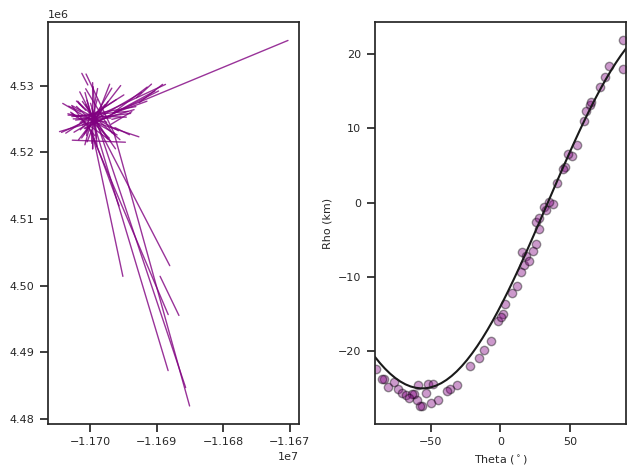

In [35]:

PurpClose, Purp=NearCenters(lines, Purp, tol=2500) # pickout all clustered lines which intersect within 2.5km of center
#tol can be changed to fit your circumstances 

#Let's plot those to take a look!

fig,ax=DotsLines(PurpClose, ColorBy=None, color='Purple')

#Plot the fit onto the data 
angles=np.linspace(-90,90) #make an array of angles from -90,90 for plotting
rhoPurp=CenterFunc(angles,Purp['Center'][0][0], Purp['Center'][0][1], xc,yc)/1000 #calculate rho values, convert to kilometers
#CenterFunc is the implementation of above equation 


ax[1].plot(angles, rhoPurp, 'k') #plot onto the HT portion of the graph

We can continue the same process to find the dikes associated with the second radial swarm by filtering by 'Ymid'. Note that depending on your application you could use any varible to filter the data or none. 

We will call this second radial fit, Green. 

km scale label


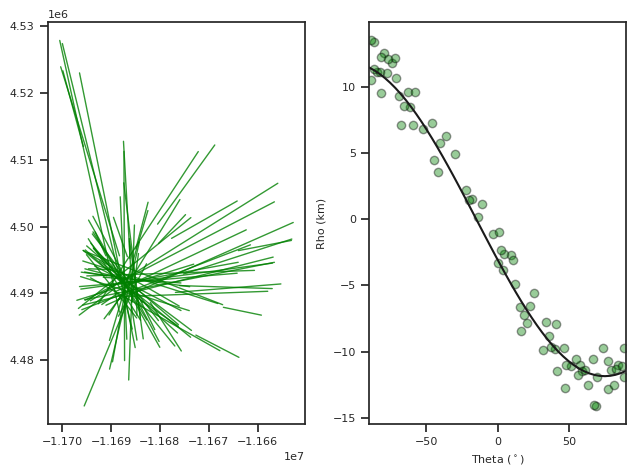

In [36]:
#Radial 2 - Green
mask2=(dikeset['Ymid']<4.52e6) & (dikeset['Ymid']>4.48e6) #Filter dataset by 'Ymid'
green=RadialFit(dikeset[mask2]) # Run dataset through RadialFit
GreenClose, green=NearCenters(lines, green, tol=2500) # find the lines which interesect within 2.5 km of Center

rhoGreen=CenterFunc(angles,green['Center'][0][0], green['Center'][0][1], xc,yc)/1000 #make array of rho values based on center

fig, ax=DotsLines(GreenClose, color='green', ColorBy=None) #graph the data that fits the center
ax[1].plot(angles, rhoGreen, 'k') #plot onto the HT portion of the graph

Now we can put it all together and extract the three features. 

We will add another column to the DataFrame called "Structure". Then we will use one new function [writeCenterWKT]() which write a WKT POINT feature.

In [ ]:
# Find labels of radial features 
radLabelsl=np.concatenate( (PurpClose['Label'].values, GreenClose['Label'].values))

# Find labels of non-radial features 
linl=lines[((~np.in1d(lines['Label'].values, radLabelsl)) & (lines['AvgTheta'].values<-55)) ]
linl=linl.assign(Structure='Linear')

#Add Structure column
GreenClose=GreenClose.assign(Structure='Radial 1') 
PurpClose=PurpClose.assign(Structure='Radial 2')

CloseLines=pd.concat((GreenClose, PurpClose, linl)) #make one dataframe called closelines
Centers=pd.concat((green, Purp)) #make one dataframe called centers

#Write to CSV with QGIS operability
writeCenterWKT(Centers, 'SpanishPeaksRadialFitsCenters.csv')
writeToQGIS(CloseLines, 'SPRadialFitsLines.csv')